Solucionarem ara el nostre cas considerant que només tenim neutrons,protons i electrons

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from physical_constants import *
from eos_functions import *

Contribució a la densitat energia pels nucleons (neutrons + protons) degut a la binding energy entre ells

\begin{align*}
e( n,x_p ) = \frac{e_0}{n_0} n \frac{ n - n_0(2+\delta) }{ n_0 + \delta n} 
+ S_0 \left( \frac{ n }{ n_0} \right)^\gamma \left( 1 - 2 x_p \right)^2
\, 
\end{align*}

In [2]:
# Paràmetres extrets del paper del model de binding energy of dense matter de H-H (Heiselberg i Hjorth-Jensen,2000)
e0=15.8    
delta=0.2  
s0=32.     
gamma=0.6  

In [3]:
num_densities=100 # Per quants valors diferents de densitat bariònica n volem trobar el valor corersponent de Pressió, i energia

n0=0.16 # Densitat de saturació bariònica de la matèria normal, en fm^{-3}

numden_i=0.5*n0 # interval de densitats n, tractarem valors de n entre numden_i (mínim valor n) i numden_f (màxim valor n)
numden_f=10*n0

# creem un vector amb tots els valors de la densitat n que volem tractar
numden=np.linspace( numden_i,numden_f,num_densities) 

Ara trobarem el valor de $x_p$ a partir de l'expressió autoconsitent que hem obtingut per $x_p$ on s'ha considerat que la interacció coulombiana entre les partícules és despreciable, que la interacció entre nucleons ve determinada per el model de binding energy de H-H comentat anteriorment, i que a més hi ha una interacció per mitjà del bosó fosc entre neutró i electró caracteritzada per el paràmetre de coupling $g=\frac{Y_eY_n}{m_{\phi}^2}$. Dit això l'expressió autoconsistent és:

\begin{align*}
x_p=\frac{1}{3\pi^2n(\hbar c)^3}((4S_o(\frac{n}{n_o})^{\gamma}-gn)(1-2x_p))^3
\, 
\end{align*}

In [100]:
g_0=-2e-5 # Unitats de MeV^-2
g=g_0*hbc3 # Unitats de MeV·fm^3

In [101]:
precisio=1e-12 # quan el valor de abs(x_p{j}-x_p{j-1}) sigui menor a la precisio donarem el valor de x_p{j} com el correcte

xp=np.zeros(num_densities)+1e-4 # per cada valor de n que considerem, comencem associant un valor que creiem aproximant per la 
                                # x_p, que iniciarà el mètode autoconsistent. Al final tots aquests valors seran modificats per 
                                # la x_p final que trobem pel mètode autoconsistent
        
# AQUÍ COMENÇA EL LOOP PER TROBAR LA X_P PER CADA VALOR DE n QUE TRACTEM

for i,n in enumerate( numden ): # i pren valors 0,1,2,... i n els valors de la densitat n que tractarem
    xpold=xp[i] 
    diff=1. # Això servirà per calcular la diferència abs(x_p{j}-x_p{j-1})
    
    S=4.*s0*np.power( n/n0,gamma )-g*n # Definim el terme energia simètrica
    
    while diff > precisio : # Aquí comença el mètode autoconsistent com a tal
        
        xpnew=(1./(3.*np.power(pi,2.)*n*hbc3))*np.power(S*(1.-2.*xpold),3.)
        
        xpold=(xpnew+xpold)/2.
        diff=np.abs( xpnew-xpold )
        
      
    xp[i]=xpnew # El vector on inicialment tenia els valors de la xp inicials, ara canvio cada valor de xp per el xpnew que 
                #correspon a la n que hem considerat

Ara ja tenim el valor de $x_p$ pel que correspon a cada valor de n, així que podem trobar $x_n=1-x_p$ i també el valor numèric de la densitat d'energia dels nucleons. 

I a partir d'aquí trobar la pressió corresponent amb l'expressió $P= n^2 \frac{\partial e}{\partial n}$ per l'energia per partícules

I si ho fem per la densitat d'energia l'expressió és $P=n\frac{\partial \epsilon}{\partial n} - \epsilon$ per la densitat d'energia

Primer però calculem els paràmetres bàsics que necessitarem

In [102]:
# Primer calculem la densitat de neutrons n_n i de protons n_p (en fm^-3)
n_p=numden*xp
n_n=numden*(1.-xp)

# Ara calculem els paràmetres principals pels electrons
electron_eden_units=np.power(m_el,4)/hbc3/3./np.power(pi,2)

mu_e=4*s0*np.power(numden/n0,gamma)*(1.-2.*xp)+g*xp*numden # potencial químic de l'electró
pf_e=np.sqrt(np.power(mu_e,2)-np.power( m_el,2)) # moment de fermi de l'electró
n_e=np.power(pf_e,3)/(3*np.power(pi,2)*hbc3) # n_e en fm^-3
x_el=n_e/numden # fracció d'electrons

I ara sí que calculem la densitat d'energia i l'energia per partícula dels nucleons

In [103]:
# Vector amb les energies per partícula per cada valor de n
e_binding=(e0/n0)*numden*((numden-n0*(2.+delta))/(n0+delta*numden)) + s0*np.power((numden/n0),gamma)*np.power((1.-2.*xp),2.)
e_coupling=g*n_e

# I ara podem trobar la densitat d'energia dels nucleons, hi ho posem en un vector en MeV fm-3
edens_n=np.zeros(num_densities)
edens_n=e_binding*numden + e_coupling*n_n + n_n*mneut + n_p*mprot

I ara a partir de la energia per partícula trobada, e, calculem la pressió que exerceixen els nucleons $P= n^2 \frac{\partial e}{\partial n}$

Així doncs el que farem serà:

derivada1=$n^2\frac{\partial (\frac{e_0}{n_0} n \frac{ n - n_0(2+\delta) }{ n_0 + \delta n})}{\partial n}$

derivada2=$n^2\frac{\partial (S_0 \left( \frac{ n }{ n_0} \right)^\gamma \left( 1 - 2 x_p \right)^2)}{\partial n}$

derivada3=$n_e^2\frac{\partial (g·n_e)}{\partial n_e}$

In [104]:
derivada1=-e0*(n0-numden)*np.power(numden,2)*( (2.+delta)*n0 + delta*numden )/( n0*np.power( n0+delta*numden,2 ) )
derivada2=s0*gamma*np.power(n0,-gamma)*np.power( (n_n - n_p),2 )*np.power(numden,gamma-1.)
derivada3=np.power(n_e,2)*g # part deguda al coupling


derivada=derivada1+derivada2+derivada3

p_nuc=derivada

Ara fem el mateix pels electrons, primer calcularem la densitat d'energia en MeV*fm^-3

In [105]:
# Ara calculem la densitat d'energia en MeV*fm-3
edens_e=electron_eden_units*energy(pf_e/m_el) # Hem fet servir funció energia definida en eos_functions.py (mirar white dwarfs)
edens_e=edens_e + g*n_n*n_e # afageixo la part degut al coupling del bosó fosc

I ara anem a calcular la pressió degut als electrons

In [106]:
# Aprofitarem la funció pressure definida en eos_functions.py per calcular la pressió (mirar white dwarfs)
derivada1_el=electron_eden_units*pressure(pf_e/m_el)
derivada2_el=np.power(n_n,2)*g # part deguda al coupling


derivada_el=derivada1_el+derivada2_el

p_el=derivada_el

I ara ho representem i guardem P(n) en un fitxer

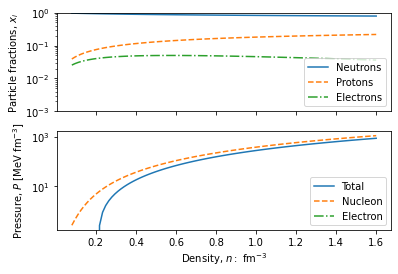

In [107]:
edens=edens_n + edens_e
press=p_nuc + p_el


# Representació fracció de partícules en funció de n
fig, (ax1,ax2) = plt.subplots(2,sharex=True)
ax1.semilogy(numden,(1-xp),label='Neutrons',lw=1.5)
ax1.semilogy(numden,xp,'--',lw=1.5,label='Protons')
ax1.semilogy(numden,x_el,'-.',lw=1.5,label='Electrons')
ax1.legend(loc='lower right')
ax1.set_ylim([1e-3,1])
ax2.set(xlabel=r'Density, $ n: $ fm$^{-3}$')
ax1.set(ylabel=r'Particle fractions, $x_i$')
ax2.set(ylabel=r'Pressure, $P$ [MeV fm$^{-3}$]')

# Representació pressió
ax2.semilogy(numden,press,label='Total',lw=1.5)
ax2.semilogy(numden,p_nuc,'--',label='Nucleon',lw=1.5)
ax2.semilogy(numden,p_el,'-.',label='Electron',lw=1.5)
ax2.legend(loc='lower right')


plt.show()


u=numden/n0
# Ho escrivim en un fitxer
data_to_write = np.array( [edens[:],press[:],u[:]] ).T
outputfile="-2e-5.dat"
with open(outputfile,"w+") as file_id :
    np.savetxt(file_id,data_to_write,fmt=["%16.6E","%16.6E","%16.6E"],header="  eden [MeVfm-3]   Pres [MeVfm-3]     Den/0.16")